In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os.path
import glob

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization

import cv2
from tqdm import tqdm

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import fbeta_score
import time
from matplotlib import pyplot as plt

%matplotlib inline

In [35]:
DATA_DIR = '/home/chicm/data/planet'
RESULT_DIR = DATA_DIR + '/resultsv2'


df_train = pd.read_csv(DATA_DIR+'/train_v2.csv')
df_test = pd.read_csv(DATA_DIR+'/sample_submission_v2.csv')

labels = ['haze', 'cultivation', 'blooming', 'partly_cloudy', 'habitation', 'primary',
            'road', 'agriculture', 'selective_logging', 'artisinal_mine', 'slash_burn',
            'blow_down', 'cloudy', 'bare_ground', 'conventional_mine', 'clear', 'water']

In [4]:
flatten = lambda l:[item for sublist in l for item in sublist]
t = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
print(t)

['blow_down', 'water', 'partly_cloudy', 'bare_ground', 'haze', 'clear', 'road', 'cultivation', 'slash_burn', 'habitation', 'agriculture', 'cloudy', 'conventional_mine', 'artisinal_mine', 'blooming', 'selective_logging', 'primary']


In [36]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(inv_label_map)

{0: 'haze', 1: 'cultivation', 2: 'blooming', 3: 'partly_cloudy', 4: 'habitation', 5: 'primary', 6: 'road', 7: 'agriculture', 8: 'selective_logging', 9: 'artisinal_mine', 10: 'slash_burn', 11: 'blow_down', 12: 'cloudy', 13: 'bare_ground', 14: 'conventional_mine', 15: 'clear', 16: 'water'}


In [37]:
img_size = (128, 128)
x_train = []
y_train = []

for f, tags in tqdm(df_train.values, miniters=10000):
    fn = DATA_DIR+'/train-jpg/'+f+'.jpg'
    img = cv2.imread(fn) 
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(cv2.resize(img, img_size))
    y_train.append(targets)
    


100%|██████████| 40479/40479 [00:39<00:00, 1035.07it/s]


In [38]:
x_train = np.array(x_train, np.float32) / 255.
y_train = np.array(y_train, np.uint8)
print(x_train.shape) 
print(y_train.shape)

(40479, 128, 128, 3)
(40479, 17)


In [44]:
x_test = []
count_add = 0
for f, tags in tqdm(df_test.values, miniters=10000):
    fn = DATA_DIR+'/test-jpg/'+f+'.jpg'
    if not os.path.isfile(fn):
        fn = DATA_DIR+'/test-jpg-add/'+f+'.jpg'
        count_add += 1
    img = cv2.imread(fn)
    x_test.append(cv2.resize(img, img_size))
print(count_add)

100%|██████████| 61191/61191 [01:12<00:00, 846.13it/s]

20522


In [45]:
x_test = np.array(x_test, np.float32) / 255.
print(x_test.shape)

(61191, 128, 128, 3)


In [11]:
print(df_train['image_name'][:2])

0    train_0
1    train_1
Name: image_name, dtype: object


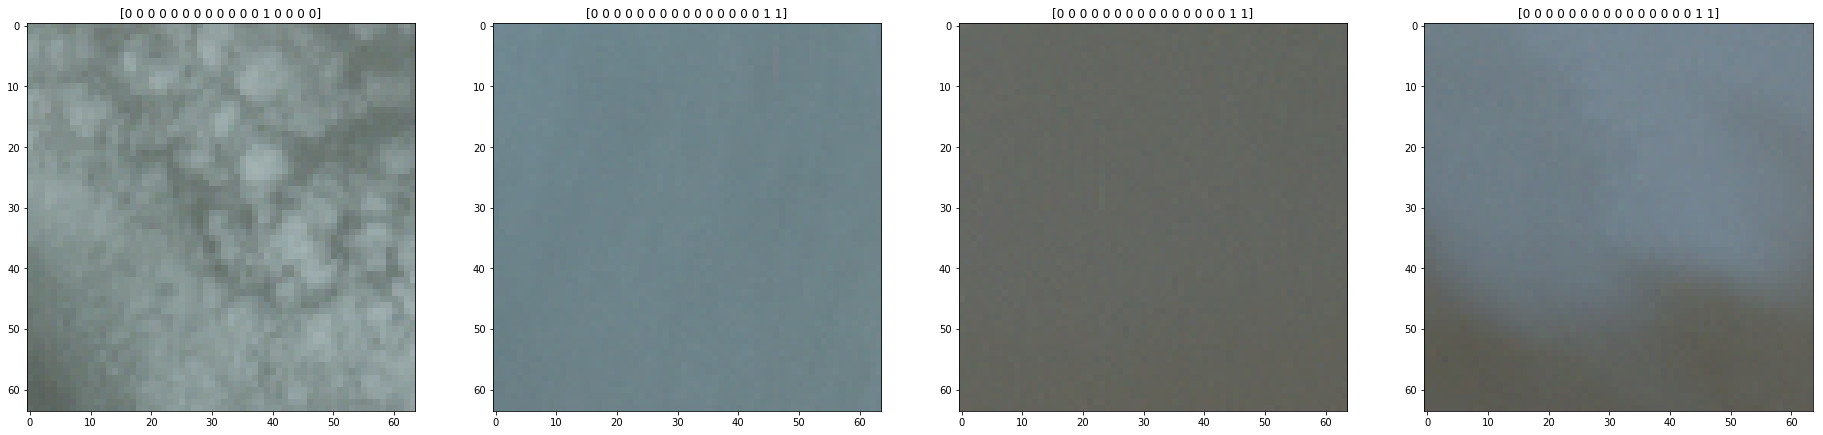

In [14]:
plt.figure(figsize=(32,32))
plt.subplot(1,4,1)
plt.imshow(x_train[26])
plt.title(y_train[26])
plt.subplot(1,4,2)
plt.imshow(x_train[273])
plt.title(y_train[273])
plt.subplot(1,4,3)
plt.imshow(x_train[290])
plt.title(y_train[290])
plt.subplot(1,4,4)
plt.imshow(x_train[412])
plt.title(y_train[412])

In [31]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Activation

def get_unet():
    inputs = Input((64, 64, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='relu')(conv9)
    result = Flatten()(conv10)
    result = Dense(17, activation='sigmoid')(result)
    
    model = Model(inputs=inputs, outputs=result)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras import backend as K

def get_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape = (128, 128, 3))),
    model.add(BatchNormalization(axis=-1)),
    model.add(Conv2D(16, (3, 3), activation='relu')),
    model.add(BatchNormalization(axis=-1)),
    model.add(MaxPooling2D(pool_size=(2, 2))),
        
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))        

    model.compile(loss='binary_crossentropy',  optimizer='adam',metrics=['accuracy'])
    
    return model

In [41]:
nfolds = 6
batch_size = 128

num_fold = 0
sum_score = 0

kf = KFold(len(y_train), n_folds=nfolds, shuffle=True, random_state=1)

for train_index, test_index in kf:
        start_time_model_fitting = time.time()
        
        X_train = x_train[train_index]
        Y_train = y_train[train_index]
        X_valid = x_train[test_index]
        Y_valid = y_train[test_index]

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        
        w_filename = RESULT_DIR + '/wconv_' + str(num_fold) + '.h5'
        
        model = get_model()
        
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, verbose=0),
            ModelCheckpoint(w_filename, monitor='val_loss', save_best_only=True, verbose=0)]
        
        model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size,verbose=2, epochs=5, shuffle=True)
        
        K.set_value(model.optimizer.lr, 0.00001)
        
        model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=batch_size, verbose=2, epochs=80, shuffle=True, callbacks = callbacks)
        
        
        p_valid = model.predict(X_valid, batch_size = batch_size, verbose=2)
        print(fbeta_score(Y_valid, np.array(p_valid) > 0.18, beta=2, average='samples'))
        
        

Start KFold number 1 from 6
Split train:  33732 33732
Split valid:  6747 6747
Train on 33732 samples, validate on 6747 samples
Epoch 1/5
38s - loss: 0.4670 - acc: 0.8167 - val_loss: 0.2817 - val_acc: 0.9106
Epoch 2/5
31s - loss: 0.1969 - acc: 0.9301 - val_loss: 0.3107 - val_acc: 0.9103
Epoch 3/5
32s - loss: 0.1698 - acc: 0.9366 - val_loss: 0.5406 - val_acc: 0.8727
Epoch 4/5
32s - loss: 0.1580 - acc: 0.9400 - val_loss: 0.1603 - val_acc: 0.9366
Epoch 5/5
32s - loss: 0.1482 - acc: 0.9429 - val_loss: 0.1928 - val_acc: 0.9250
Train on 33732 samples, validate on 6747 samples
Epoch 1/80
36s - loss: 0.1416 - acc: 0.9455 - val_loss: 0.1338 - val_acc: 0.9471
Epoch 2/80
32s - loss: 0.1394 - acc: 0.9460 - val_loss: 0.1316 - val_acc: 0.9484
Epoch 3/80
32s - loss: 0.1388 - acc: 0.9465 - val_loss: 0.1307 - val_acc: 0.9484
Epoch 4/80
32s - loss: 0.1380 - acc: 0.9466 - val_loss: 0.1313 - val_acc: 0.9478
Epoch 5/80
32s - loss: 0.1368 - acc: 0.9470 - val_loss: 0.1302 - val_acc: 0.9488
Epoch 6/80
32s - lo

## ensemble

In [46]:
import bcolz
import glob

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]


PREDICTS_FILE = RESULT_DIR + '/preds'

def ensemble():
    preds = []
    w_files = glob.glob(RESULT_DIR +'/wconv_*.h5')
    for fn in w_files:
        model = get_model()
        print(fn)
        model.load_weights(fn)
        preds.append(model.predict(x_test, batch_size=128))
    m = np.mean(preds, axis=0)
    print(m.shape)
    save_array(PREDICTS_FILE, m)
    return m

In [47]:
result = ensemble()

result = pd.DataFrame(result, columns = labels)
result

/home/chicm/data/planet/resultsv2/wconv_5.h5
/home/chicm/data/planet/resultsv2/wconv_3.h5
/home/chicm/data/planet/resultsv2/wconv_4.h5
/home/chicm/data/planet/resultsv2/wconv_2.h5
/home/chicm/data/planet/resultsv2/wconv_6.h5
/home/chicm/data/planet/resultsv2/wconv_1.h5
(61191, 17)


,haze,cultivation,blooming,partly_cloudy,habitation,primary,road,agriculture,selective_logging,artisinal_mine,slash_burn,blow_down,cloudy,bare_ground,conventional_mine,clear,water
0,0.002282,0.001152,0.007417,0.000157,0.000439,0.999537,0.001956,0.002205,0.000570,0.000054,0.000096,0.000445,0.000285,0.000360,0.000035,0.999130,0.006381
1,0.000715,0.003500,0.012611,0.001527,0.000834,0.999433,0.003365,0.004024,0.001773,0.000121,0.000178,0.000813,0.000473,0.000362,0.000058,0.998265,0.010875
2,0.000020,0.008655,0.000013,0.999564,0.000539,0.998762,0.008366,0.039851,0.000012,0.000013,0.000016,0.000012,0.000703,0.000042,0.000003,0.000066,0.036886
3,0.001383,0.007506,0.007806,0.007181,0.001555,0.998597,0.006056,0.011330,0.001824,0.000164,0.000290,0.000800,0.000883,0.000760,0.000085,0.990166,0.017417
4,0.002283,0.001846,0.000082,0.501018,0.000938,0.436492,0.008180,0.018032,0.000045,0.000060,0.000022,0.000037,0.550392,0.000225,0.000045,0.001707,0.034938
5,0.000326,0.000598,0.002263,0.000087,0.000161,0.999666,0.000807,0.001365,0.000165,0.000008,0.000026,0.000139,0.000234,0.000090,0.000006,0.999535,0.002520
6,0.085211,0.220040,0.001899,0.254308,0.139351,0.988512,0.312776,0.608390,0.005095,0.003962,0.004658,0.001481,0.004334,0.023026,0.001650,0.643094,0.405633
7,0.002256,0.010192,0.000101,0.001455,0.887690,0.815533,0.951758,0.225530,0.000574,0.004287,0.000098,0.000072,0.002508,0.012728,0.000894,0.993042,0.126930
8,0.000587,0.001203,0.004099,0.000170,0.000498,0.999521,0.002168,0.002402,0.000457,0.000037,0.000065,0.000277,0.000250,0.000262,0.000022,0.999461,0.005090
9,0.876548,0.042462,0.000698,0.010119,0.010125,0.985020,0.054970,0.158937,0.000601,0.000378,0.000880,0.000701,0.008518,0.003040,0.000350,0.219986,0.115348


In [48]:
from tqdm import tqdm

preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0.18, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:36<00:00, 635.99it/s]


In [49]:
df_test['tags'] = preds
df_test

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,partly_cloudy primary
3,test_3,primary clear
4,test_4,partly_cloudy primary cloudy
5,test_5,primary clear
6,test_6,cultivation partly_cloudy primary road agricul...
7,test_7,habitation primary road agriculture clear
8,test_8,primary clear
9,test_9,haze primary clear


In [50]:
df_test.to_csv(RESULT_DIR+'/v2_sub2.csv', index=False)

In [30]:
%pwd


'/home/chicm/ml/planet'